
## Testing segmentation model on a video example

In [18]:
# imports

import os
import cv2
import numpy as np
import glob
import tensorflow as tf
from keras.models import load_model
from moviepy.editor import *
from natsort import natsorted
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt

In [19]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# directory = "/content/drive/MyDrive/"
directory = "/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/"

In [21]:
frames = []

file_list = glob.glob(f"{directory}frames_to_test_segmentation/*.png")  # Get all the pngs in the current directory
file_list_sorted = natsorted(file_list,reverse=False)

for file in file_list_sorted:
    img = cv2.imread(file, 1)
    img = cv2.resize(img, (384, 384))
    frames.append(img)

frames_to_test = np.array(frames)
len(frames_to_test)

871

In [22]:
model = load_model('/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/psp_softmax_1500_resnet50.hdf5', compile=False)

In [23]:
preprocess_input = sm.get_preprocessing('resnet50')

In [24]:
results = []

for frame in frames_to_test:
    frame_input = np.expand_dims(frame, 0)
    test_frame = preprocess_input(frame_input)
    test = model.predict(test_frame)
    test_pred = np.argmax(test, axis=3)[0,:,:]

    results.append(test_pred)

preds = np.array(results)

1/1 [==============================] - 0s 21ms/step


In [25]:
b_test = 0
n_test = 0
o_test = 0
s_test = 0

for y in results[700]:
  b_test += y.size - np.count_nonzero(y)
  n_test += np.count_nonzero(y == 1)
  o_test += np.count_nonzero(y == 2)
  s_test += np.count_nonzero(y == 3)
  
print("background: ", round(b_test))
print("needle: ", round(n_test))
print("oocyte: ", round(o_test))
print("spermatozoid: ", round(s_test))

background:  98652
needle:  4280
oocyte:  44408
spermatozoid:  116


In [26]:
img = frames_to_test[360]
mask = results[360].astype(np.uint8)

needle_mask = results[360].astype(np.uint8)
needle_mask[needle_mask != 1] = 0

oocyte_mask = results[360].astype(np.uint8)
oocyte_mask[oocyte_mask != 2] = 0

spermatozoid_mask = results[360].astype(np.uint8)
spermatozoid_mask[spermatozoid_mask != 3] = 0

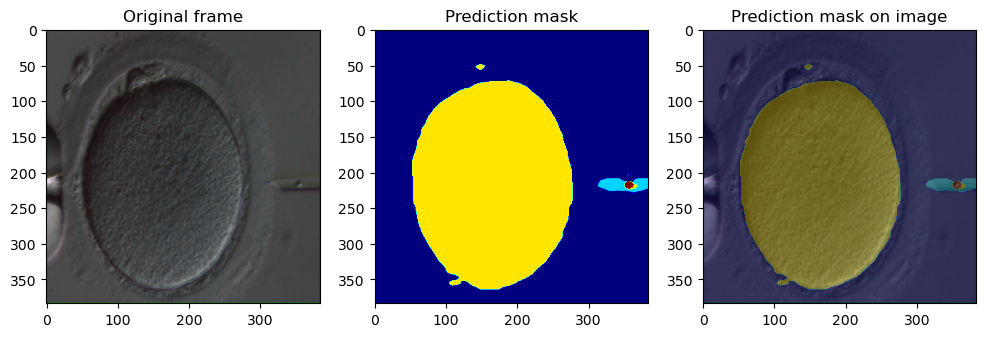

In [27]:

# 670 pęcherzyk powietrza

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Original frame')
plt.imshow(frames_to_test[360], vmin=0, vmax=3, cmap='gray')
plt.subplot(232)
plt.title('Prediction mask')
plt.imshow(results[360], vmin=0, vmax=3, cmap='jet')
plt.subplot(233)
plt.title('Prediction mask on image')
plt.imshow(frames_to_test[360], vmin=0, vmax=3, cmap='gray')
plt.imshow(results[360], vmin=0, vmax=3, cmap="jet", alpha=0.3)
plt.show()

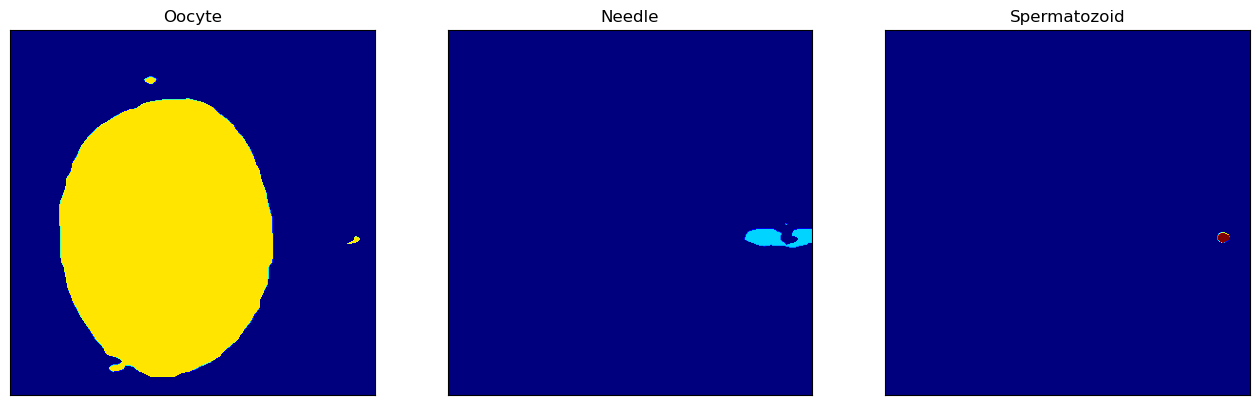

In [28]:
masks = [oocyte_mask, needle_mask, spermatozoid_mask]
classes = ['oocyte', 'needle', 'spermatozoid']

n = len(masks)
plt.figure(figsize=(16, 5))

for (i, mask) in enumerate(masks):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(classes[i].split('_')).title())
    plt.imshow(mask, vmin=0, vmax=3, cmap='jet')


In [29]:
count = 0

for i,m in zip(frames_to_test, results):
  #print("Frame", count)
  #print("Unique masks in frame: ", np.unique(result))
  """
  needle_mask = m.astype(np.uint8)
  needle_mask[needle_mask != 1] = 0
  # needle_mask = cv2.applyColorMap(needle_mask, colormap=0)
  """
  """
  oocyte_mask = m.astype(np.uint8)
  oocyte_mask[oocyte_mask != 2] = 0
  #oocyte_mask= cv2.applyColorMap(oocyte_mask, colormap=8)
  """

  spermatozoid_mask = m.astype(np.uint8)
  spermatozoid_mask[spermatozoid_mask != 3] = 0
  """
  spermatozoid_mask = cv2.applyColorMap(spermatozoid_mask, colormap=3)
  """

  # combined_masks = (oocyte_mask & needle_mask & spermatozoid_mask)

  # dst = cv2.addWeighted(i, 0.8, oocyte_mask, 0.3, 0)
  # dst = cv2.bitwise_not(i,i, mask=mask)
  dst = cv2.bitwise_not(i,i, spermatozoid_mask)

  #dst = cv2.bitwise_or(i,i, mask=spermatozoid_mask)

  cv2.imwrite(f'{directory}/unet_test_results/frames_{str(count)}.png', dst)
  count += 1

In [30]:
def convert_frames_to_video(path):
        base_dir = os.path.realpath(path)
        print(base_dir)

        file_list = glob.glob(f'{base_dir}/*.png')  # Get all the pngs in the current directory
        file_list_sorted = natsorted(file_list,reverse=False)


        fps = 25

        clips = [ImageClip(m).set_duration(0.04)
                for m in file_list_sorted]

        concat_clip = concatenate_videoclips(clips, method="compose")
        concat_clip.write_videofile("test.mp4", fps=fps)

In [31]:
convert_frames_to_video('/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/segmentation_test_results')

/media/madziegielewska/Seagate Expansion Drive/MAGISTERKA/diploma-project/unet_test_results
Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
